In this notebook we test an XGBoost model

Import All Packages

In [1]:
import time
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics


from sklearn.preprocessing import OneHotEncoder
from matplotlib.pyplot import cm
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score, average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

sns.set(style="white", color_codes=True)
%matplotlib inline



C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Load All Data

In [6]:
def load_data(file_name, maxLines):

    """
        Import dataset
    """
    
    col_acq = ['LoanID','Channel','SellerName','OrInterestRate','OrUnpaidPrinc','OrLoanTerm',
            'OrDate','FirstPayment','OrLTV','OrCLTV','NumBorrow','DTIRat','CreditScore',
            'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
            'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd']
    
    extended_selec_acq = ['LoanID', 'OrLTV', 'LoanPurpose', 'DTIRat', 'PropertyType', 'FTHomeBuyer', 'Channel', 'SellerName','OrInterestRate', 'CreditScore', 'NumBorrow', 'OrDate'] 
    col_acq_subset = extended_selec_acq 
    
    col_per = ['LoanID','MonthRep','Servicer','CurrInterestRate','CAUPB','LoanAge','MonthsToMaturity',
              'AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag','ZeroBalCode','ZeroBalDate',
              'LastInstallDate','ForeclosureDate','DispositionDate','PPRC','AssetRecCost','MHRC',
              'ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP','OFP','NIBUPB','PFUPB','RMWPF',
              'FPWA','ServicingIndicator'] 
    
    extended_selec_per = ['LoanID', 'MonthsToMaturity', 'CurrInterestRate', 'ForeclosureDate', 'LoanAge', 'CLDS', 'MaturityDate','ZeroBalCode', 'MonthRep']
    
    col_per_subset =  extended_selec_per 
    
    lines_to_read = maxLines
    aquisition_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Acquisition_2007Q4.txt', sep='|', names=col_acq, usecols=col_acq_subset, index_col=False, nrows=lines_to_read )
    performance_frame = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/Performance_2007Q4.txt', sep='|', names=col_per, usecols=col_per_subset, index_col=False, nrows=lines_to_read) 

    """ Fix the IDs in the observation set by fixing their reporting date AND requiring that the files are healthy. """
    
    observation_frame = performance_frame[((performance_frame.CLDS == '0') | 
                                           (performance_frame.CLDS == '1') | 
                                           (performance_frame.CLDS == '2')
                                          )
                                         ]
    obs_ids = observation_frame.LoanID
    
    """ Load only the observation IDs in the performance frame initially. """
    pf = performance_frame[performance_frame.LoanID.isin(obs_ids)]
    
    """ Keep only the reporting dates that are in our performance period (MM/DD/YYYY format). """
    pf_obs = pf[
                    (pf.MonthRep == '01/01/2018') | 
                    (pf.MonthRep == '02/01/2018') |
                    (pf.MonthRep == '03/01/2018') |
                    (pf.MonthRep == '04/01/2018') |
                    (pf.MonthRep == '05/01/2018') |
                    (pf.MonthRep == '06/01/2018') |
                    (pf.MonthRep == '07/01/2018') |
                    (pf.MonthRep == '08/01/2018') |
                    (pf.MonthRep == '09/01/2018') |
                    (pf.MonthRep == '10/01/2018') |
                    (pf.MonthRep == '11/01/2018') |
                    (pf.MonthRep == '12/01/2018') 
                ]
    
    """ 
    Find the LoanIDs of those loans where a default appears in our performance period.
    """
    pf_obs_defaults = pf_obs[
                            (pf_obs.CLDS != '0') &
                            (pf_obs.CLDS != '1') &
                            (pf_obs.CLDS != '2') &
                            (pf_obs.CLDS != 'X')
                        ].LoanID
    
    pf_obs_defaults.drop_duplicates(keep='last', inplace=True)
    
    """ Merge the acquisition and performance frames. """
    df = pd.merge(aquisition_frame, observation_frame, on = 'LoanID', how='inner')
    
    df['Default'] = 0
    df.loc[df['LoanID'].isin(pf_obs_defaults), 'Default'] = 1
    
    export_csv = df.to_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/ML4Credit/PD/df.csv')
    
    return df

In [ ]:
load_data(None, 10000).head()

In [6]:
def label_encode(df):
    df = df.apply(LabelEncoder().fit_transform)
    return df

In [7]:
def one_hot_encode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    df = enc.transform(df)
    return df

In [8]:
def get_na_columns(df):
    na_columns = df.columns[df.isnull().any()]
    return na_columns

In [9]:
def get_cat_feat(df):
    cat_feat = df.select_dtypes(include=['object']).columns
    return cat_feat

def get_num_feat(df):
    num_feat = df.select_dtypes(exclude=['object']).columns
    return num_feat

In [10]:
def normalize(df):
    df_norm = df
    df_norm = df_norm.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return df_norm

In [11]:
def makeDateNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[3:7])
    result = (numYears - 2000) * 12 + numMonths
    return result


def makeDayNumeric(text):
    numMonths = int(text[:2])
    numYears = int(text[6:10])
    result = (numYears - 2000) * 12 + numMonths
    return result

def make_dates_numeric(df):
    # TRANSFORM DATES TO NUMBER OF MONTHS (STARTING FROM 01/2000)
    df['MonthRep'] = df['MonthRep'].apply(makeDayNumeric)
    df['OrDate'] = df['OrDate'].apply(makeDateNumeric)
    df['FirstPayment'] = df['FirstPayment'].apply(makeDateNumeric)
    df['MaturityDate'] = df['MaturityDate'].apply(makeDateNumeric)

In [12]:
def to_2D(df):
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df)
    df_2D = pd.DataFrame(df_2D)
    return df_2D

In [13]:
def tsne_visual(df):   
        # TSNE - Dimentionality reduction
    print ('Training T-SNE ...')

    tsne = TSNE(n_components=2, random_state=1, n_iter=250, verbose=1)
    df_2D = tsne.fit_transform(df.drop('Default', axis=1))
    df_2D = pd.DataFrame(df_2D)
    
    
    #Making plot
    plt.figure(figsize=(20,10))
    color = cm.rainbow(np.linspace(0,1, max(map(abs, set(df['Default'])))+1))
    for i in range(0, len(df_2D)):
        c1 = plt.scatter(df_2D.iloc[i][0], 
                         df_2D.iloc[i][1],
                     c = color[int(df.iloc[i]['Default'])],
                     marker=r"$ {} $".format(int(df.iloc[i]['Default'])), s=150, edgecolors='none')

    plt.xlabel('T-SNE Dim 1')
    plt.ylabel('T-SNE Dim 2')
    plt.title('Actives')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('Actives' + '.pdf', format='pdf', dpi=900)
    plt.show()

MAIN

In [21]:
df = load_data(maxLines=1000000, duplicates=False)
df.head()

,LoanID,Channel,SellerName,OrInterestRate,OrDate,OrLTV,NumBorrow,DTIRat,CreditScore,FTHomeBuyer,...,PropertyType,MonthRep,CurrInterestRate,LoanAge,MonthsToMaturity,MaturityDate,CLDS,ZeroBalCode,ForeclosureDate,Default
0,100008184591,B,OTHER,6.625,11/2007,64,1.0,53.0,585.0,N,...,SF,12/01/2017,5.00,120,240,12/2037,0,NaN,NaN,1
1,100013284158,B,"BANK OF AMERICA, N.A.",6.625,10/2007,27,1.0,54.0,591.0,N,...,SF,12/01/2017,4.25,121,432,12/2053,0,NaN,NaN,0
2,100039990921,C,"BANK OF AMERICA, N.A.",6.500,10/2007,95,2.0,37.0,677.0,N,...,SF,12/01/2017,6.50,121,239,11/2037,0,NaN,NaN,0
3,100058998523,B,"FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",6.500,12/2007,50,1.0,43.0,588.0,N,...,SF,12/01/2017,4.50,119,445,01/2055,1,NaN,NaN,0
4,100081051863,C,"FDIC, RECEIVER, INDYMAC FEDERAL BANK FSB",6.500,06/2007,73,1.0,19.0,623.0,N,...,SF,12/01/2017,6.50,125,235,07/2037,0,NaN,NaN,0


In [3]:
# FORCE FEATURES TO BE INCLUDED
df = df[pd.notnull(df['CreditScore'])]
df = df[pd.notnull(df['DTIRat'])]

# FORCE FEATURES TO BE EXCLUDED
df = df.drop('LoanID',axis=1)
df = df.drop('CLDS',axis=1)

# FORCE FEATURE TO BE CATEGORICAL
# df['Zip'] = df['Zip'].astype('object',copy=False)
# df['MSA'] = df['MSA'].astype('object',copy=False)

# DROP FEATURES WITH NA VALUES
na_columns = get_na_columns(df)
df = df.drop(na_columns,axis=1)

# FIND THE CATEGORICAL FEATURES
cat_feat = get_cat_feat(df)
cat_data = df[cat_feat]
print(cat_feat)

# PERFORM LABEL ENCODIGN ON THE CATEGORICAL DATA
cat_data = label_encode(cat_data)

# FIND AND NORMALIZE THE NUMERICAL DATA
num_feat = get_num_feat(df)
num_data = normalize(df[num_feat])


df = pd.concat([num_data, cat_data], axis=1)
print(df.columns)

KeyError: 'CreditScore'

Training T-SNE ...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1832 samples in 0.023s...
[t-SNE] Computed neighbors for 1832 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1832
[t-SNE] Computed conditional probabilities for sample 1832 / 1832
[t-SNE] Mean sigma: 1.454797
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.698532
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


No handles with labels found to put in legend.


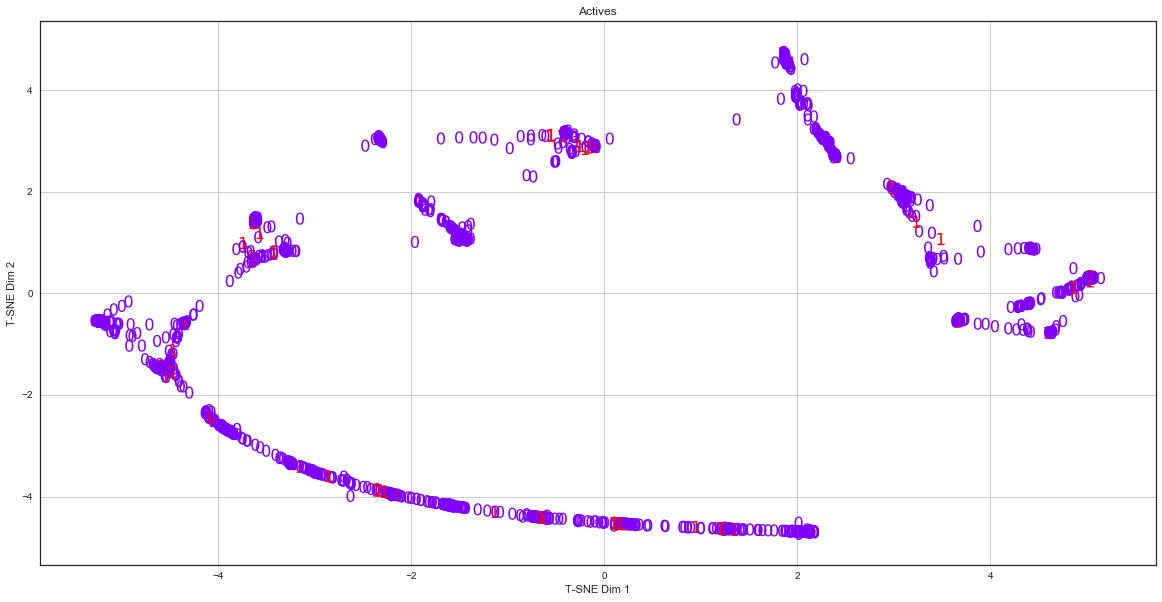

In [23]:
# TRY TO SEPERATE THE DEFAULTS FROM THE OTHER LOANS IN A VISUAL WAY
tsne_visual(df)

In [24]:
df.head()

,OrInterestRate,OrLTV,NumBorrow,DTIRat,CreditScore,CurrInterestRate,LoanAge,MonthsToMaturity,Default,Channel,SellerName,OrDate,FTHomeBuyer,LoanPurpose,PropertyType,MonthRep,MaturityDate
0,0.538462,0.629213,0.000000,0.816667,0.370667,0.436364,0.035714,0.501040,1.0,0,10,14,0,2,4,0,214
1,0.538462,0.213483,0.000000,0.833333,0.386667,0.327273,0.071429,0.900208,0.0,0,1,12,0,0,4,0,225
2,0.512821,0.977528,0.333333,0.550000,0.616000,0.654545,0.071429,0.498960,0.0,1,1,12,0,2,4,0,194
3,0.512821,0.471910,0.000000,0.650000,0.378667,0.363636,0.000000,0.927235,0.0,0,4,17,0,0,4,0,19
4,0.512821,0.730337,0.000000,0.250000,0.472000,0.654545,0.214286,0.490644,0.0,1,4,5,0,0,4,0,111


In [25]:
"""
    Split the target variable from the input variables.
""" 
y = df['Default']
X = df.drop(['Default'], axis=1)

In [26]:
print(y.value_counts())
df.head()

0.0    1729
1.0     103
Name: Default, dtype: int64


,OrInterestRate,OrLTV,NumBorrow,DTIRat,CreditScore,CurrInterestRate,LoanAge,MonthsToMaturity,Default,Channel,SellerName,OrDate,FTHomeBuyer,LoanPurpose,PropertyType,MonthRep,MaturityDate
0,0.538462,0.629213,0.000000,0.816667,0.370667,0.436364,0.035714,0.501040,1.0,0,10,14,0,2,4,0,214
1,0.538462,0.213483,0.000000,0.833333,0.386667,0.327273,0.071429,0.900208,0.0,0,1,12,0,0,4,0,225
2,0.512821,0.977528,0.333333,0.550000,0.616000,0.654545,0.071429,0.498960,0.0,1,1,12,0,2,4,0,194
3,0.512821,0.471910,0.000000,0.650000,0.378667,0.363636,0.000000,0.927235,0.0,0,4,17,0,0,4,0,19
4,0.512821,0.730337,0.000000,0.250000,0.472000,0.654545,0.214286,0.490644,0.0,1,4,5,0,0,4,0,111


In [27]:
from imblearn.over_sampling import RandomOverSampler

In [29]:
# DUPLICATES SOME LOANS TO HAVE MORE BALANCED DATA
from imblearn.over_sampling import RandomOverSampler
sm = RandomOverSampler()

n_1 = sum(y)
n_0 = len(y) - sum(y)

X_cols = X.columns
X, y = sm.fit_sample(X, y) # fit_sample takes a dataframe, but returns an array. 
(X, y) = (pd.DataFrame(X, columns=X_cols), pd.Series(y))
print(y.value_counts())

0.0    1729
1.0    1729
dtype: int64


In [31]:
# DIVIDE THE DATA IN 10 STRATIFIED FOLDS
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [32]:
from xgboost import XGBClassifier
model = XGBClassifier()

In [33]:
for train_index, test_index in skf.split(X, y):
    
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print(y_train.isnull().values.any())
    
    # fit model on training data
    model.fit(X_train, y_train)
    
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    
    # evaluate predictions
    auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0), "|| AUC: %.2f%%" % (auc * 100.0), "|| F1 - Score: %.2f%%" % (f1 * 100.0))

False
Accuracy: 86.71% || AUC: 86.71% || F1 - Score: 87.57%
False
Accuracy: 87.28% || AUC: 87.28% || F1 - Score: 87.85%
False
Accuracy: 89.31% || AUC: 89.31% || F1 - Score: 89.58%
False
Accuracy: 87.86% || AUC: 87.86% || F1 - Score: 88.20%
False
Accuracy: 90.17% || AUC: 90.17% || F1 - Score: 90.66%
False
Accuracy: 90.17% || AUC: 90.17% || F1 - Score: 90.45%
False
Accuracy: 88.15% || AUC: 88.15% || F1 - Score: 88.77%
False
Accuracy: 85.55% || AUC: 85.55% || F1 - Score: 86.49%
False
Accuracy: 89.02% || AUC: 89.02% || F1 - Score: 89.78%
False
Accuracy: 88.95% || AUC: 88.95% || F1 - Score: 89.78%


             precision    recall  f1-score   support

        0.0       0.97      0.81      0.88       172
        1.0       0.83      0.97      0.90       172

avg / total       0.90      0.89      0.89       344



Text(1,1,'Sampling algorithm: RandomOverSampling')

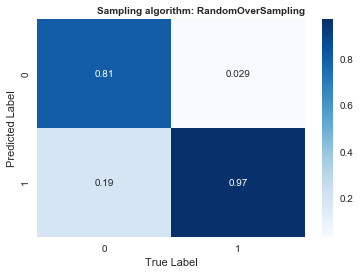

In [34]:
"""
    Output statistics - confusion matrix
"""

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred).T
cm = cm.astype('float')/cm.sum(axis=0)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('Sampling algorithm: ' + "RandomOverSampling", loc='right', fontsize=10, fontweight='bold')

In [24]:
df = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/ML4Credit/PD/trainData.csv', sep=',', index_col=0)
df.head()

C:\Users\bebxadvberb\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3,9,12,14,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LoanID,MonthRep,Servicer,CurrInterestRate,CAUPB,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA,...,PFUPB,RMWPF,FPWA,ServicingIndicator,Arrears,Arrears_3m,Arrears_6m,Arrears_9m,Arrears_12m,0
478929,1.068260e+11,03/01/2016,NaN,3.625,103595.27,16.0,164.0,160.0,11/2029,19660.0,...,NaN,NaN,NaN,N,0.0,0.0,0.0,0.0,0.0,NaN
9671,1.001533e+11,06/01/2016,NaN,4.750,110702.69,49.0,311.0,311.0,05/2042,44700.0,...,NaN,NaN,NaN,N,0.0,0.0,0.0,0.0,0.0,NaN
747903,1.105839e+11,06/01/2017,NaN,4.875,228080.45,92.0,268.0,268.0,10/2039,40060.0,...,NaN,NaN,NaN,N,0.0,0.0,0.0,0.0,0.0,NaN
716840,1.101734e+11,06/01/2016,NaN,2.875,82377.72,35.0,145.0,145.0,07/2028,33660.0,...,NaN,NaN,NaN,N,0.0,1.0,2.0,4.0,4.0,NaN
684819,1.096985e+11,06/01/2017,NaN,4.500,188723.31,67.0,293.0,293.0,11/2041,13460.0,...,NaN,NaN,NaN,N,0.0,0.0,0.0,0.0,0.0,NaN


In [23]:
# DROP FEATURES WITH NA VALUES
na_columns = get_na_columns(df)
df = df.drop(na_columns,axis=1)

""
478929
9671
747903
716840
684819


In [15]:
# FIND THE CATEGORICAL FEATURES
cat_feat = get_cat_feat(df)
cat_data = df[cat_feat]
print(cat_feat)

Index(['MonthRep', 'MaturityDate', 'ModFlag'], dtype='object')


In [16]:
# PERFORM LABEL ENCODIGN ON THE CATEGORICAL DATA
cat_data = label_encode(cat_data)

In [17]:
# FIND AND NORMALIZE THE NUMERICAL DATA
num_feat = get_num_feat(df)
num_data = normalize(df[num_feat])

In [18]:
df = pd.concat([num_data, cat_data], axis=1)
print(df.columns)

Index(['LoanID', 'CurrInterestRate', 'LoanAge', 'MonthsToMaturity', 'MSA',
       'CLDS', 'Arrears', 'Arrears_3m', 'MonthRep', 'MaturityDate', 'ModFlag'],
      dtype='object')


In [19]:
df.head()

,LoanID,CurrInterestRate,LoanAge,MonthsToMaturity,MSA,CLDS,Arrears,Arrears_3m,MonthRep,MaturityDate,ModFlag
478929,0.483583,0.382353,0.156863,0.249406,0.395255,0.0,0.0,0.0,0,276,0
9671,0.010750,0.647059,0.480392,0.598575,0.898673,0.0,0.0,0.0,2,125,0
747903,0.749865,0.676471,0.901961,0.496437,0.805388,0.0,0.0,0.0,3,260,0
716840,0.720775,0.205882,0.343137,0.204276,0.676719,0.0,0.0,0.5,2,163,0
684819,0.687129,0.588235,0.656863,0.555819,0.270607,0.0,0.0,0.0,3,288,0


In [20]:
# TRY TO SEPERATE THE DEFAULTS FROM THE OTHER LOANS IN A VISUAL WAY
tsne_visual(df)

Training T-SNE ...


KeyError: "labels ['Default'] not contained in axis"

In [ ]:
df2 = pd.read_csv('C:/Users/bebxadvberb/Documents/AI/Trusted AI/ML4Credit/PD/trainData.csv', sep=',', index_col=0)
df2.head()